# Dealing with Bias and Variance

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import scipy.io
import numpy as np
import pandas as pd
from time import time
from addutils import css_notebook
from sklearn import metrics

css_notebook()


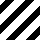
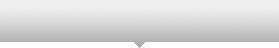
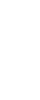
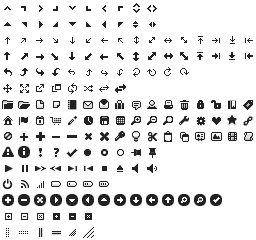
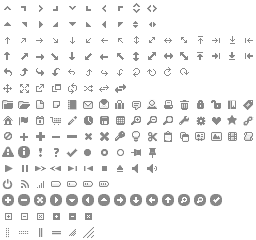
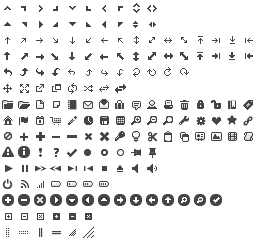
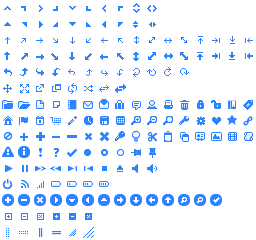
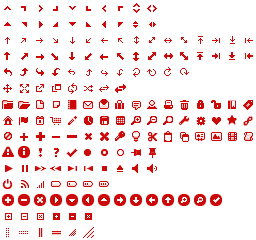
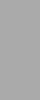
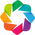
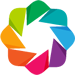
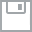
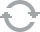
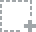
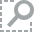
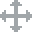
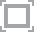
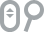

In [3]:
import bokeh.plotting as bk
bk.output_notebook()

## 1 Bias-Variance Tradeoff

**TODO -** Put the following function definitions in an external folder

In [4]:
from bokeh.models.ranges import Range1d

def test_func(x, err=0.5):
    return np.random.normal(10 - 1. / (x + 0.1), err)

def compute_error(x, y, p):
    yfit = np.polyval(p, x)
    return np.sqrt(np.mean((y - yfit) ** 2))

def plot_bias_variance(N=8, random_seed=42, err=0.5):
    np.random.seed(random_seed)
    x = 10 ** np.linspace(-2, 0, N)
    y = test_func(x)
    xfit = np.linspace(-0.2, 1.2, 1000)
    titles = ['d = 1 (under-fit; high bias)',
              'd = 2',
              'd = 6 (over-fit; high variance)']
    degrees = [1, 2, 6]
    
    row = []
    for i, d in enumerate(degrees):
        fig = bk.figure(plot_width=300, plot_height=300,
                        title=titles[i], x_range=(-0.2, 1.2), y_range=(0, 12))
        fig.title_text_font_size = '11pt'
        fig.xaxis.axis_label_text_font_size = '9pt'
        fig.yaxis.axis_label_text_font_size = '9pt'
        fig.x(x, y, color='black', size=12)
        
        p = np.polyfit(x, y, d)
        yfit = np.polyval(p, xfit)
        fig.line(xfit, yfit, line_color='blue')
        
        fig.xaxis.axis_label = 'house size'
        fig.xaxis.axis_label_text_font_size = '9pt'
        if i == 0:
            fig.yaxis.axis_label = 'price'
        row.append(fig)

    gp = bk.gridplot([row], border_space=0)
    bk.show(gp)

In this figure, we use polynomials with different degrees `d` to fit the same data.

For `d=1`, the model suffers from **high bias**: the model complexity is not enough to represent the data.

At the other extreme, for `d=6` the model suffers from **high variance**: the data is over-fit and the model has too many free parameters.  In this case a typical behaviour is that if any of the input points are varied slightly, it could result in a very different model. This kind of model will fit very well training data while failing the fit on validation data.

In the middle, for `d=2`, we have found a good model.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
plot_bias_variance(8, random_seed=42, err=10)

### 1.1 Bias-Variance Tradeoff explained with a regression example

For this section, we'll explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

We consider the situation where we have only 2 data points:

In [7]:
from sklearn import linear_model
X = np.array([0.5, 1.0]).reshape(2,1)
y = np.array([0.5, 1.0])
X_test = np.array([0.0, 2.0]).reshape(2,1)
regr = linear_model.LinearRegression()
regr.fit(X, y)
fig = bk.figure(plot_width=400, plot_height=300, title=None)
fig.circle(X[:,0], y, size=5)
fig.line(X_test[:,0], regr.predict(X_test), color='green')
bk.show(fig)

In real life situation, we have noise (e.g. measurement noise) in our data:

In [8]:
import seaborn as sns
import addutils.palette as pal
import random
cat_colors = map(pal.to_hex, sns.color_palette('bright', 6))
random.shuffle(cat_colors)

In [9]:
np.random.seed(0)
fig = bk.figure(plot_width=400, plot_height=300, title=None)

for i in range(6):
    noise = np.random.normal(loc=0, scale=.1, size=X.shape)
    noisy_X = X + noise
    regr.fit(noisy_X, y)
    
    fig.circle(noisy_X[:,0], y, size=8, fill_color=cat_colors[i], line_color='black')
    fig.line(X_test[:,0], regr.predict(X_test), color=cat_colors[i])
bk.show(fig)

As we can see, our linear model captures and amplifies the noise in the data. It displays a lot of variance. We can use another linear estimator that uses **regularization**: the Ridge estimator. This estimator regularizes the coefficients by shrinking them to zero, under the assumption that very high correlations are often spurious. High alphas give high regularization (shrinkage):

In [10]:
regr = linear_model.Ridge(alpha=0.08)

fig = bk.figure(plot_width=400, plot_height=300, title=None)
for i in range(6):
    noise = np.random.normal(loc=0, scale=.1, size=X.shape)
    noisy_X = X + noise
    regr.fit(noisy_X, y)
    fig.circle(noisy_X[:,0], y, size=8, color=cat_colors[i], line_color='black')
    fig.line(X_test[:,0], regr.predict(X_test), color=cat_colors[i])
bk.show(fig)

As we can see, the estimator displays much less variance. However it systematically under-estimates the coefficient. It displays a biased behavior.

With the next examples we will try to answer the following question: **If our estimator is underperforming, how should we move forward?**

- Do I need a Simple or more Complicated Model ?
- Do I need More Training Samples ?
- Do I need more features for each observed data point ?

The answer is often counter-intuitive. In particular, **Sometimes using a more complicated model will give _worse_ results.**  Also, **Sometimes adding training data will not improve your results.**  The ability to determine what steps will improve your model is what separates the successful machine
learning practitioners from the unsuccessful.

## 2 Regularization: what it is and why it is necessary

**The core idea behind regularization is that we are going to prefer models that are simpler**, even if they lead to more errors on the train set. Here we start to define a 9th order polynomial function. This represents our 'ground truth'. You can imagine this like a signal we measured at diffrent times:

In [11]:
f = lambda t: 1.2*t**2 + 0.1*t**3 - 0.6*t**5 - 0.8*t**9
gt_coeff = [0, 0, 1.2, 0.1, 0., -0.6, 0., 0., 0., -0.8]

Unfortunately in real life every measure is affected by a measurement error that we simulate with the variable `noise_level`.
Our ground truth is a 9th order polynomial, so it could seem obvious that we must use a 9th order polynomial to fit it. If you play a little with the following code you will discover that if you don't use any regularization technique (`LinearRegression` doesn't allow any regularization), most of the time it's much better to use a simpler (lower-order) model to avoid overfitting.

Try to change the following variables:

* `orders`: orders of the polynomials to fit
* `n_samples`: when the number of the samples is small it's difficult to fit a high-order model and you have overfitting
* `noise_level`: whit very low noise it's easier to fit higher-order polynomials

*Mind that we didn't fix the random generator seed, so every time you run the cell you'll have a different noise distribution on the samples*.

**As you can see we use a linear algorithm to fit a nonlinear function, this is possible because we use the linear algorithm to fit the nonlinear coefficients that we define in the regressors**.

In [12]:
tmin, tmax = -1.1, 1.0
n_samples = 20
noise_level = 0.2
orders = [4, 9]
np.random.seed(1)
t = tmin + np.random.rand(n_samples) * (tmax-tmin)              # Sample points
y_noisy = f(t) + noise_level*np.random.normal(size=n_samples)   # Noisy measure

fig = bk.figure(plot_width=800, plot_height=640,
                title='4th and a 9th order polynomial with Ground truth')
fig.circle(t, y_noisy, size=8, fill_alpha=0.5)

p = np.linspace(tmin, tmax, 200)                                # Array to calc. the prediction
colors = ['blue', 'green']
for order in orders:
    X = np.array([t**i for i in range(order+1)]).T              # Regressor
    Xp = np.array([p**i for i in range(order+1)]).T             # Regressor for prediction
    poly_linreg = linear_model.LinearRegression().fit(X, y_noisy)
    fig.line(p, poly_linreg.predict(Xp), legend='linreg order: %02i' % order,
             color=colors.pop())

fig.line(p, f(p), legend="truth", color='red', line_width=3.0)
fig.legend.label_text_font_size = '14pt'
fig.legend.orientation = 'top_left'

np.set_printoptions(precision=2)
print 'Ground Truth coeff.: ', ' '.join(['%+5.1f' %n for n in gt_coeff])
print 'LinReg coefficients: ', ' '.join(['%+5.1f' %n for n in poly_linreg.coef_])

bk.show(fig)

Ground Truth coeff.:   +0.0  +0.0  +1.2  +0.1  +0.0  -0.6  +0.0  +0.0  +0.0  -0.8
LinReg coefficients:   +0.0  -0.2  +4.2  +1.8 -30.8 -24.9 +60.3 +53.3 -27.9 -26.8


Now we compare the previous `LinearRegression` algorithm with the `Lasso` algorithm.

`Lasso` (least absolute shrinkage and selection operator) is an alternative regularized version of least squares: it is a **shrinkage estimator**: unlike `ridge regression`, as the penalty term increases, lasso sets more coefficients to zero, this means that the lasso estimator produces smaller models.

In [13]:
order = 9
np.random.seed(1)
X = np.array([t**i for i in range(order+1)]).T
Xp = np.array([p**i for i in range(order+1)]).T
poly_linreg = linear_model.LinearRegression().fit(X, y_noisy)
poly_lasso = linear_model.Lasso(alpha = 0.005).fit(X, y_noisy)

fig = bk.figure(plot_width=800, plot_height=640)
fig.circle(t, y_noisy, size=8, alpha=0.5)
fig.line(p, poly_linreg.predict(Xp), legend='linreg order: %02i' % order, color='royalblue')
fig.line(p, poly_lasso.predict(Xp), legend='lasso order: %02i' % order,
         line_width=3.0, color='green')
fig.line(p, f(p), legend="truth", color='red', line_width=3.0)

fig.legend.label_text_font_size = '15pt'
fig.legend.orientation = 'top_left'
fig.title = 'LinReg and Lasso with Ground truth'

np.set_printoptions(precision=2)
print 'Ground Truth coeff.: ', ' '.join(['%+5.1f' %n for n in gt_coeff])
print 'LinReg coefficients: ', ' '.join(['%+5.1f' %n for n in poly_lasso.coef_])
bk.show(fig)

Ground Truth coeff.:   +0.0  +0.0  +1.2  +0.1  +0.0  -0.6  +0.0  +0.0  +0.0  -0.8
LinReg coefficients:   +0.0  -0.2  +0.0  -0.0  +0.7  -0.2  +1.0  -0.0  +0.3  -0.0


Try by yourself: play a little with the code of the two previous cells by changing `n_samples` and `noise_level` to verify that:

* When `n_samples` is very high (>1000) it's very unlikely to have overfitting. This means that with more data it's possible to fit more complex models without overfitting.
* When `n_samples` is very low (<40) it's almost impossible to fit with Linear Regression without overfitting. In this case regularization is always required
* When `n_samples` is very high (>1000) and `noise_level` is very low, the Lasso algorithm keeps just the coefficients actually used to calculate the ground truth function. This means that Lasso can deal with high dimesional problems where most of the features can be neglected producing compact linear models.

## 3 Do I need a Simple or a Complex Model ?

We'll choose the best model complexity by plotting the **Validation Curves**.

Now we generate some example data. Here **Training Data** are plotted in **Blue** while **Validation Data** are **Red**:

In [14]:
from sklearn import cross_validation
N = 100
test_size = 0.40
error = 1.0
np.random.seed(1)
x = np.random.random(N)
y = test_func(x, error)
x_tr, x_valid, y_tr, y_valid = cross_validation.train_test_split(x, y, test_size=test_size)
fig = bk.figure(plot_width=400, plot_height=300, title=None)
fig.circle(x_tr, y_tr, color='blue', size=4)
fig.circle(x_valid, y_valid, color='red', size=4)
bk.show(fig)

The **model parameters** *(in our case, the coefficients of the polynomials)* are learned using the **training set**.

The **meta-parameters** *(in our case, the degree of the polynomial)* are adjusted so that this **validation error** is minimized.

Finally, the labels are predicted for the **test set**.

The **validation error** of our polynomial classifier can be visualized by plotting the error as a function of the polynomial degree:

In [15]:
import warnings
warnings.filterwarnings('ignore', message='Polyfit*')

degrees = np.arange(41)
train_err = np.zeros(len(degrees))
validation_err = np.zeros(len(degrees))

for i, d in enumerate(degrees):
    p = np.polyfit(x_tr, y_tr, d)
    train_err[i] = compute_error(x_tr, y_tr, p)
    validation_err[i] = compute_error(x_valid, y_valid, p)

fig = bk.figure(plot_width=600, plot_height=400, title=None)

fig.line(degrees, validation_err,
         line_width=2, legend='cross-validation error', color='royalblue')
fig.line(degrees, train_err, line_width=2, legend='training error', color='green')
fig.line([0, 20], [error, error], line_dash='dashed', legend='intrinsic error', color='black')

fig.xaxis.axis_label = 'degree of fit'
fig.yaxis.axis_label = 'rms error'

fig.grid.grid_line_color = None

bk.show(fig)

For this toy dataset, error = 1.0 is the best we can hope to obtain. Choosing `d=6` in this case gets us very close to the optimal error.

Notice that in the above plot, `d=6` gives the best results. But in the very first example, we found that `d=6` vastly over-fits the data. What’s going on here? The difference is the **number of training points** used:

**As a general rule of thumb, the more training points used, the more complicated model can be used.**

## 4 Do I need More Training Samples ?

The following code will plot two **Validation Curves** as a **function of the number of training points**:

In [16]:
def plot_learning_curve(d, N=100, y_range=None):
    test_size = 0.40
    n_sizes = 50       # Number of testing point in which to split the size
    n_runs = 20        # Number of times to run the test for each training set size
    sizes = np.linspace(2, N, n_sizes).astype(int)
    train_err = np.zeros((n_runs, n_sizes))
    validation_err = np.zeros((n_runs, n_sizes))
    for run in range(n_runs):
        for nsize, size in enumerate(sizes):
            x_tr, x_valid, y_tr, y_valid = cross_validation.train_test_split(x, y,
                                           test_size=test_size, random_state=run)
            # Train on only the first `size` points
            p = np.polyfit(x_tr[:size], y_tr[:size], d)
            # Validation error is on the *entire* validation set
            validation_err[run, nsize] = compute_error(x_valid, y_valid, p)
            # Training error is on only the points used for training
            train_err[run, nsize] = compute_error(x_tr[:size], y_tr[:size], p)

    fig = bk.figure(plot_width=400, plot_height=300, title='d = %i' % d,
                    x_range=(0, N-1)) 
    fig.title_text_font_size = '11pt'
    fig.xaxis.axis_label_text_font_size = '9pt'
    fig.yaxis.axis_label_text_font_size = '9pt'
    
    fig.line(sizes, validation_err.mean(axis=0), 
             line_width=2, legend='mean validation error', color='royalblue')
    fig.line(sizes, train_err.mean(axis=0),
             line_width=2, legend='mean training error', color='green')
    fig.line([0, N], [error, error],
             line_dash='dashed', legend='intrinsic error', color='black')
    
    fig.xaxis.axis_label = 'traning set size'
    fig.yaxis.axis_label = 'rms error'
    fig.legend.orientation = 'top_right'
    
    if y_range:
        fig.y_range = Range1d(y_range[0], y_range[1])

    fig.grid.grid_line_color = None
    bk.show(fig)

In [17]:
plot_learning_curve(d=1, N=100)

The validation error *generally decreases* with a growing training set, while the training error *generally increases* with a growing training set.

From the above discussion, we know that `d=1` where **d is the maximum degree of the polynomial** is a **high-bias estimator** which under-fits the data. This is indicated by the fact that **both the training and validation errors are very high**. When confronted with this type of learning curve, we can expect that **adding more training data will not help**: both lines will converge to a relatively high error.

**When BOTH TRAINING AND VALIDATION curves CONVERGE TO AN HIGH ERROR, we have a HIGH BIAS MODEL.** we don't need more  data but we can try one of the following actions:

* Using a more sophisticated model (i.e. in this case, increase ``d``)
* Gather more features for each sample.
* Decrease regularlization in a regularized model.

Now let's look at a high-variance (i.e. over-fit) model:

In [18]:
plot_learning_curve(d=10, N=100, y_range=(0,12))

We see that `d=20` is a **high-variance** estimator which **over-fits** the data. This is indicated by the fact that the
training error is much less than the validation error.

**When the learning curves have not yet converged with our full training set, it indicates a HIGH VARIANCE MODEL, and we are in an OVERFIT condition.**

A high-variance model can be improved by:

* Gathering more training samples.
* Using a less-sophisticated model (i.e. in this case, make ``d`` smaller)
* Increasing regularization.

*In particular, gathering more features for each sample will not help the results.*

## 5 Feature importance

Generally speaking, a **high bias** model can be improved by using more features for each sample while a **high variance** model can be improved by reducing the number of features. In other words, an high bias model don't take in consideration something that can be available by using more features, while a high variance model will overfit trying to model meaningless features.

The problem here is to discover the **feature importance**. This can be obtained with some algoritms that can perform the fitting and evaluate the feature importance at the same time.

In this example we use two different `ensemble` algorithms on the *Boston Housing Dataset*: first we use a `RandomForestRegressor` algotithm with a `Grid Search` Cross Validation, then we run a `GradientBoostingRegressor` on the same dataset.

Let's start by reading the *Boston Housing Dataset* and storing it properly in a `pandas DataFrame`:

In [19]:
from sklearn import datasets, cross_validation, ensemble, metrics, grid_search
warnings.filterwarnings("ignore", category=DeprecationWarning)
data = datasets.load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)#[:-1])
# Assign more descriptive names, see data.DESCR for more info
df = df.rename(columns={u'CRIM':'Per Capita Crime Rate',
                        u'ZN':'Land_zn / lots_over_25k_sqft',
                        u'INDUS':'Prop non-retail business acres',
                        u'CHAS':'Bounds Charles River',
                        u'NOX':'NOX Concentration',
                        u'RM':'Avg Rooms per Dwelling',
                        u'AGE':'Prop units built prior 1940',
                        u'DIS':'Distance from Biz Centers',
                        u'RAD':'Accessibility to Highways',
                        u'TAX':'Property TAX rate per $10k',
                        u'PTRATIO':'Pupil-Teacher Ratio',
                        u'B':'Prop of Blacks',
                        u'LSTAT':'% Lower pop Status'})

Split the data in **Training and Validation Set**:

In [20]:
idx_train, idx_valid = cross_validation.train_test_split(df.index, test_size=0.20)
df_train, df_valid = df.ix[idx_train], df.ix[idx_valid]
y_train, y_valid = data.target[idx_train], data.target[idx_valid]

Run the `GridSearchCV` to find the best `RandomForestRegressor`:

In [21]:
param_grid = [{'n_estimators': [25, 50, 100, 200],
               'max_depth': [16, 32],
               'min_samples_split' : [2, 4],
               'min_samples_leaf' : [1],
               'bootstrap' : [True]}]
t0 = time()
rfr = grid_search.GridSearchCV(ensemble.RandomForestRegressor(),
                               param_grid, cv=5, verbose=0)
rfr.fit(df_train, y_train)
print 'Done in %0.3f[s]' %(time() - t0)

Done in 14.777[s]


In [22]:
best_estimator = rfr.best_estimator_
for key, value in rfr.best_params_.items():
    print key.ljust(20), ':', value

y_predic = best_estimator.predict(df_valid)

fig = bk.figure(plot_width=400, plot_height=300)
fig.title_text_font_size = '11pt'
fig.circle(y_valid, y_predic, size=5)

fig.title = "True vs Predicted Price"
fig.xaxis.axis_label = 'True price ($1000s)'
fig.yaxis.axis_label = 'Predicted price ($1000s)'
fig.axis.axis_label_text_font_size = '9pt'
fig.grid.grid_line_color = None
fig.axis.minor_tick_out = 0
fig.axis.major_tick_out = 0
fig.axis.major_tick_in = 3

bk.show(fig)

min_samples_split    : 4
n_estimators         : 25
bootstrap            : True
max_depth            : 16
min_samples_leaf     : 1


In [23]:
feature_importance = best_estimator.feature_importances_
feature_importance = 100.0*(feature_importance/feature_importance.max())
feature_importance_sorted_idx = np.argsort(feature_importance)
print feature_importance_sorted_idx

[ 1  8  3  2  9 11 10  6  0  4  7  5 12]


In [24]:
cols = list(df.columns[feature_importance_sorted_idx])
fig = bk.figure(plot_width=800, plot_height=400, 
                title='Variable Importance',
                y_range=cols, x_range=(0, 100))
fig.title_text_font_size = '10.5pt'
fig.segment(0, cols,  
            feature_importance[feature_importance_sorted_idx], cols,
            line_width=20)
fig.xaxis.axis_label = 'Relative Importance'
fig.xaxis.axis_label_text_font_size = '9pt'

bk.show(fig)

Now do the same with the `GradientBoostingRegressor`, the order and distribution of the features importance can vary because we used a different algorithm, can you spot the differences?

**TODO -** Add the deviance as shown in http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

In [25]:
gbr = ensemble.GradientBoostingRegressor(max_depth=3,
                                         n_estimators=1000)
t0 = time()
gbr.fit(df_train, y_train)
print 'Done in %0.3f[s]' %(time() - t0)

Done in 0.697[s]


In [26]:
y_predic = gbr.predict(df_valid)

feature_importance = gbr.feature_importances_
feature_importance = 100.0*(feature_importance/feature_importance.max())
feature_importance_sorted_idx = np.argsort(feature_importance)

cols = list(df.columns[feature_importance_sorted_idx])
fig = bk.figure(plot_width=800, plot_height=400,
                title='Variable Importance',
                y_range=cols, x_range=(0, 100))
fig.title_text_font_size = '10.5pt'
fig.segment(0, cols,  
            feature_importance[feature_importance_sorted_idx], cols,
            line_width=20)
fig.xaxis.axis_label = 'Relative Importance'
fig.xaxis.axis_label_text_font_size = '9pt'

bk.show(fig)

In [27]:
n_features = len(df.columns)
depths = range(2,25)
f_importance_idxs = np.zeros((len(depths),n_features), dtype=int)

In [28]:
n_estimators = 5000
for i, depth in enumerate(depths):
    gbr = ensemble.GradientBoostingRegressor(max_depth=depth, n_estimators=n_estimators)
    t0 = time()
    gbr.fit(df, data.target)
    print '%02d'%(depth),np.argsort(gbr.feature_importances_),'Done in %05.2f[s]' %(time()-t0)
    f_importance_idxs[i,:] = np.argsort(gbr.feature_importances_)

02 

[ 3  1  8  9 10  2  4 11  6 12  7  0  5] Done in 02.71[s]
03

 [ 3  1  8  9 10  2  4  6 11  7 12  5  0] Done in 02.87[s]
04

 [ 3  1  8  9 10  2  4 11  7  6  5 12  0] Done in 02.23[s]
05

 [ 3  1  8  9 10  2  4 11  6  7 12  0  5] Done in 01.81[s]
06

 [ 3  1  8  9  2 10  4 11  6  7  5  0 12] Done in 01.60[s]
07

 [ 3  1  8  9  2 10  4 11  6  7  0  5 12] Done in 01.42[s]
08

 [ 3  1  2  8  9 10  4  6 11  7  0 12  5] Done in 01.32[s]
09

 [ 3  1  8  2  9 10  4 11  6  7  0  5 12] Done in 01.25[s]
10

 [ 3  1  8  2  9 10  4 11  6  0  7 12  5] Done in 01.13[s]
11

 [ 3  1  8  2 10  9  4 11  6  0  7 12  5] Done in 01.08[s]
12

 [ 3  1  8  2 10  9 11  4  6  0  7 12  5] Done in 01.08[s]
13

 [ 3  1  2  8  6 11 10  9  0  4  7 12  5] Done in 01.08[s]
14

 [ 3  1  2  8  6 11 10  9  0  4  7 12  5] Done in 01.13[s]
15

 [ 3  1  2  8  6 11  9 10  0  4  7 12  5] Done in 01.10[s]
16

 [ 3  1  2  8  6 11  9 10  0  4  7 12  5] Done in 01.12[s]
17

 [ 3  1  2  8  6 11  9 10  0  4  7 12  5] Done in 01.11[s]
18

 [ 3  1  2  8  6 11  9 10  0  4  7 12  5] Done in 01.10[s]
19

 [ 3  1  2  8  6 11  9 10  0  4  7 12  5] Done in 01.10[s]
20

 [ 3  1  2  8  6 11  9 10  0  4  7 12  5] Done in 01.10[s]
21

 [ 3  1  2  8  6 11  9 10  0  4  7 12  5] Done in 01.14[s]
22

 [ 3  1  2  8  6 11  9 10  0  4  7 12  5] Done in 01.27[s]
23

 [ 3  1  2  8  6 11  9 10  0  4  7 12  5] Done in 01.14[s]
24

 [ 3  1  2  8  6 11  9 10  0  4  7 12  5] Done in 01.24[s]


In [29]:
fig = bk.figure(plot_width=500, plot_height=800,
                x_range=(0, 10), y_range=(0, 10),
                title=None)

fig.axis.major_tick_line_color = None
fig.axis.minor_tick_line_color = None
fig.axis.major_label_text_color = None

colors = map(pal.to_hex, sns.color_palette('Paired', 13))
fig.image([f_importance_idxs[::-1, :]], [0], [0], dw=10, dh=10, palette=colors)
bk.show(fig)

In [30]:
gbr.feature_importances_

array([  6.65e-04,   1.82e-05,   3.60e-05,   1.67e-05,   1.00e-03,
         1.20e-02,   2.03e-04,   1.58e-03,   6.16e-05,   3.31e-04,
         3.69e-04,   2.65e-04,   5.69e-03])

In [31]:
for feature in df.columns[np.argsort(gbr.feature_importances_)]:
    print feature

Bounds Charles River
Land_zn / lots_over_25k_sqft
Prop non-retail business acres
Accessibility to Highways
Prop units built prior 1940
Prop of Blacks
Property TAX rate per $10k
Pupil-Teacher Ratio
Per Capita Crime Rate
NOX Concentration
Distance from Biz Centers
% Lower pop Status
Avg Rooms per Dwelling


## 6 Do the right thing

### 6.1 Hight Bias

If our algorithm shows high **bias**, the following actions might help:

- **Add more features**. In our example of predicting home prices,
  it may be helpful to make use of information such as the neighborhood
  the house is in, the year the house was built, the size of the lot, etc.
  Adding these features to the training and test sets can improve
  a high-bias estimator
- **Use a more sophisticated model**. Adding complexity to the model can
  help improve on bias. For a polynomial fit, this can be accomplished
  by increasing the degree d. Each learning technique has its own
  methods of adding complexity.
- **Use fewer samples**. Though this will not improve the classification,
  a high-bias algorithm can attain nearly the same error with a smaller
  training sample. For algorithms which are computationally expensive,
  reducing the training sample size can lead to very large improvements
  in speed.
- **Decrease regularization**. Regularization is a technique used to impose
  simplicity in some machine learning models, by adding a penalty term that
  depends on the characteristics of the parameters. If a model has high bias,
  decreasing the effect of regularization can lead to better results.

### 6.2 High Variance

If our algorithm shows **high variance**, the following actions might help:

- **Use fewer features**. Using a feature selection technique may be
  useful, and decrease the over-fitting of the estimator.
- **Use a simpler model**.  Model complexity and over-fitting go hand-in-hand.
- **Use more training samples**. Adding training samples can reduce
  the effect of over-fitting, and lead to improvements in a high
  variance estimator.
- **Increase Regularization**. Regularization is designed to prevent
  over-fitting. In a high-variance model, increasing regularization
  can lead to better results.

These choices become very important in real-world situations. For example,
due to limited telescope time, astronomers must seek a balance between
observing a large number of objects, and observing a large number of
features for each object. Determining which is more important for a
particular learning task can inform the observing strategy that the
astronomer employs. In a later exercise, we will explore the use of
learning curves for the photometric redshift problem.

### 6.3 More Sophisticate Methods

There are a lot more options for performing validation and model testing.
In particular, there are several schemes for cross-validation, in which
the model is fit multiple times with different training and test sets.
The details are different, but the principles are the same as what we've
seen here.

For more information see the ``sklearn.cross_validation`` module documentation,
and the information on the scikit-learn website.

### 6.4 One Last Caution

Using validation schemes to determine hyper-parameters means that we are
fitting the hyper-parameters to the particular validation set.  In the same
way that parameters can be over-fit to the training set, hyperparameters can
be over-fit to the validation set.  Because of this, the validation error
tends to under-predict the classification error of new data.

For this reason, it is recommended to split the data into three sets:

- The **training set**, used to train the model (usually ~60% of the data)
- The **validation set**, used to validate the model (usually ~20% of the data)
- The **test set**, used to evaluate the expected error of the validated model (usually ~20% of the data)

This may seem excessive, and many machine learning practitioners ignore the need
for a test set.  But if your goal is to predict the error of a model on unknown
data, using a test set is vital.

## 7 Additional examples on Regularization: ridge Regression and Stocastic Gradient Descent (SGD)

`LinearRegression` fits a linear model with coefficients `w = (w1, ..., wp)` to minimize the residual sum of squares between the observed responses in the dataset, and the responses predicted by the linear approximation.

Mathematically it solves a problem of the form: <img src='files/utilities/ols_problem.png' >

However, coefficient estimates for Ordinary Least Squares rely on the independence of the model terms. When terms are correlated and the columns of the design matrix **X** have an approximate linear dependence, the design matrix becomes close to singular and as a result, the least-squares estimate becomes highly sensitive to random errors in the observed response, producing a large variance.

In [32]:
diabetes = datasets.load_diabetes() # Diabetes is a dataset with 442 samples and 10 attributes
X = pd.DataFrame(diabetes.data)
y = pd.DataFrame(diabetes.target)

warnings.filterwarnings("ignore", category=DeprecationWarning)
X[X.columns[0:3]].head()            # Show the first 3 attributes for the first 5 samples

,0,1,2
0,0.038076,0.050680,0.061696
1,-0.001882,-0.044642,-0.051474
2,0.085299,0.050680,0.044451
3,-0.089063,-0.044642,-0.011595
4,0.005383,-0.044642,-0.036385


In [33]:
X[X.columns[0:3]].describe()       # Describe the first three columns

,0,1,2
count,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.639623e-16,1.309912e-16,-8.013951e-16
std,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02
max,1.107267e-01,5.068012e-02,1.705552e-01


In [34]:
zip(X.columns, [type(x) for x in X.ix[0,:]])  # Check the datatypes of the columns

[(0, numpy.float64),
 (1, numpy.float64),
 (2, numpy.float64),
 (3, numpy.float64),
 (4, numpy.float64),
 (5, numpy.float64),
 (6, numpy.float64),
 (7, numpy.float64),
 (8, numpy.float64),
 (9, numpy.float64)]

Keep just the attributes in the column number 3 and use 25% of the data as a testing set:

In [35]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(np.array(X[X.columns[2:3]]),\
                                                                     np.array(y),\
                                                                     test_size=0.25, random_state=0)


In [36]:
regr1 = linear_model.LinearRegression().fit(X_train, y_train)

fig = bk.figure(plot_width=640, plot_height=300, title=None)
fig.circle(X_test[:,0], y_test[:,0], color='black')
fig.line(X_test[:,0], regr1.predict(X_test)[:,0], color='blue', line_width=3)
bk.show(fig)

### 7.1 Ridge Regression

Linear Regression rely on the independence of the model terms. When terms are correlated and the columns of the design matrix &Chi; have an approximate linear dependence, the matrix (&Chi;<sup>T</sup>&Chi;)<sup>-1</sup> becomes
close to singular. As a result, the least-squares estimate becomes highly sensitive to random errors in the observed response *y*, producing a large variance. This situation of multicollinearity can arise, for example, when data are collected without an experimental design.

The ridge coefficients minimize a penalized residual sum of squares, <img src='files/utilities/penalized_residuals_sum_of_squares.png'>

Here, positive $\alpha  \geq 0 \hspace{2 pt}$ is a complexity parameter that controls the amount of shrinkage: the larger the value of $\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity.

In [37]:
regr2 = linear_model.Ridge(alpha = 0.5)
regr2.fit(X_train, y_train)

fig = bk.figure(plot_width=640, plot_height=330, title=None)
fig.circle(X_test[:,0], y_test[:,0], color='black')
fig.line(X_test[:,0], regr1.predict(X_test)[:,0], color='blue', line_width=3)
fig.line(X_test[:,0], regr2.predict(X_test)[:,0], color='red', line_width=3)
bk.show(fig)

Keep all the 10 attributes and split training and testing sets:

In [38]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(np.array(X),\
                                                                     np.array(y),\
                                                                     test_size=0.25, random_state=0)


Fit the ridge regressor on all the attributes and calculate the fits for a given $\alpha$

In [39]:
regr3 = linear_model.Ridge(alpha = 0.6)
regr3.fit(X_train, y_train)
print 'Coefficients: ', regr3.coef_
print ('Variance score: %.2f' % regr3.score(X_test, y_test))

Coefficients:  [[  11.2   -91.95  372.15  211.51   -5.48  -54.35 -170.41  117.16  304.
    98.04]]
Variance score: 0.37


The larger the value of $\alpha  \geq 0 \hspace{2 pt}$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity. Nevertheless, the value of $\alpha \hspace{2 pt}$ cannot be increased indefinitely: there is an optimal point above which the variance scores and residual sum of squales drop sharply:

In [40]:
n_alphas = 200
alphas = np.logspace(-5, 1, n_alphas)
regr3 = linear_model.Ridge(fit_intercept=False)

scores = []
for a in alphas:
    regr3.set_params(alpha=a)
    regr3.fit(X_train, y_train)
    scores.append(regr3.score(X_test, y_test))

fig = bk.figure(plot_width=640, plot_height=330,
                title=r'Variance Scores as a function of alpha',
                x_axis_type='log', x_range=(min(alphas), max(alphas)))
fig.title_text_font_size = '11pt'
fig.xaxis.axis_label = 'alpha'
fig.yaxis.axis_label = 'scores'
fig.axis.axis_label_text_font_size = '10pt'
fig.line(alphas, scores, line_color='blue')
bk.show(fig)

### 7.2 Stochastic Gradient Descent (SGD)

`Stochastic Gradient Descent` is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.

SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing. Given that the data is sparse, the classifiers in this module easily scale to problems with more than 10^5 training examples and more than 10^5 features.

In [41]:
from sklearn.datasets.samples_generator import make_regression

X, y = make_regression(n_samples=100000, n_features=1, n_informative=1,\
                        random_state=0, noise=35)

reg3 = linear_model.SGDRegressor(alpha=0.1, n_iter=20)
reg3.fit(X, y)

fig = bk.figure(plot_width=630, plot_height=300, title=None)
fig.circle(X[::1000, 0], y[::1000],  color='black')
fig.line(X[::1000, 0], reg3.predict(X[::1000]), color='red', line_width=3)
fig.grid.grid_line_color = None
fig.axis.minor_tick_out = 0
bk.show(fig)

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.